# joule-profiler Quick Start

Basic visualization of energy consumption data from joule-profiler.

## RAPL Domain Hierarchy

**Important:** RAPL domains are hierarchical:
- `PSYS` = Platform (entire system)
- `PACKAGE` = CPU package (includes CORE + UNCORE)
- `CORE` = CPU cores (subset of PACKAGE)
- `UNCORE` = Uncore (subset of PACKAGE)

**Do not sum all domains** as this would double-count energy!

## Load Data

This notebook works with simple mode data in both formats:
- JSON: `simple.json`, `simple-iterations.json`
- CSV: `simple.csv`, `simple-iterations.csv`

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Simple Mode - Single Measurement (JSON)

In [2]:
# Load simple.json
data = pd.read_json('../examples/data/simple.json', typ='series')
data

duration_ms                                                 2768
energy_uj      {'CORE_0': 9962987, 'PACKAGE-0_0': 17384844, '...
exit_code                                                      0
mode                                                      simple
dtype: object

In [3]:
# Convert energy from µJ to J
df = pd.DataFrame([
    {'Domain': domain, 'Energy (J)': uj / 1_000_000}
    for domain, uj in data['energy_uj'].items()
])

df

,Domain,Energy (J)
0,CORE_0,9.962987
1,PACKAGE-0_0,17.384844
2,PSYS_1,44.210641
3,UNCORE_0,0.010376


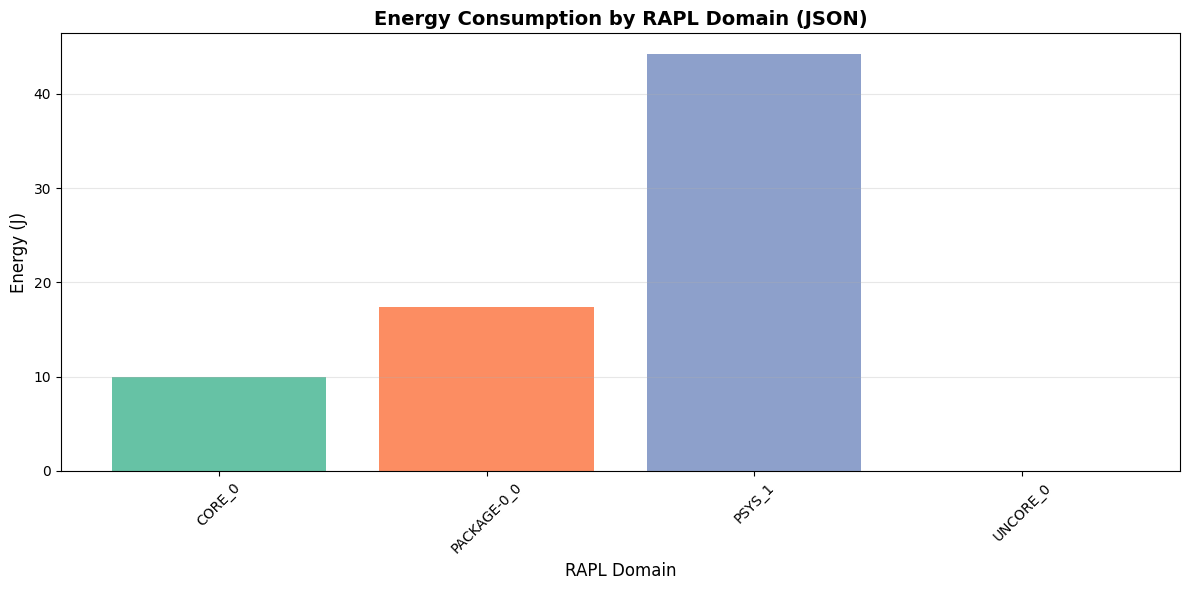

In [4]:
# Visualize energy consumption
fig, ax = plt.subplots(figsize=(12, 6))

colors = sns.color_palette('Set2', len(df))
ax.bar(df['Domain'], df['Energy (J)'], color=colors)
ax.set_title('Energy Consumption by RAPL Domain (JSON)', fontsize=14, fontweight='bold')
ax.set_ylabel('Energy (J)', fontsize=12)
ax.set_xlabel('RAPL Domain', fontsize=12)
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()

## 2. Simple Mode - Single Measurement (CSV)

In [5]:
# Load simple.csv - directly usable!
df_csv = pd.read_csv('../examples/data/simple.csv', sep=';')
df_csv

,CORE_0_uj,PACKAGE-0_0_uj,PSYS_1_uj,UNCORE_0_uj,duration_ms,exit_code
0,11297029,20961189,54493269,20264,3207,0


In [6]:
# Convert µJ to J for visualization
energy_cols = [col for col in df_csv.columns if col.endswith('_uj')]

# Create plotting DataFrame
df_csv_plot = pd.DataFrame({
    'Domain': [col.replace('_uj', '') for col in energy_cols],
    'Energy (J)': [df_csv[col].iloc[0] / 1_000_000 for col in energy_cols]
})

df_csv_plot

,Domain,Energy (J)
0,CORE_0,11.297029
1,PACKAGE-0_0,20.961189
2,PSYS_1,54.493269
3,UNCORE_0,0.020264


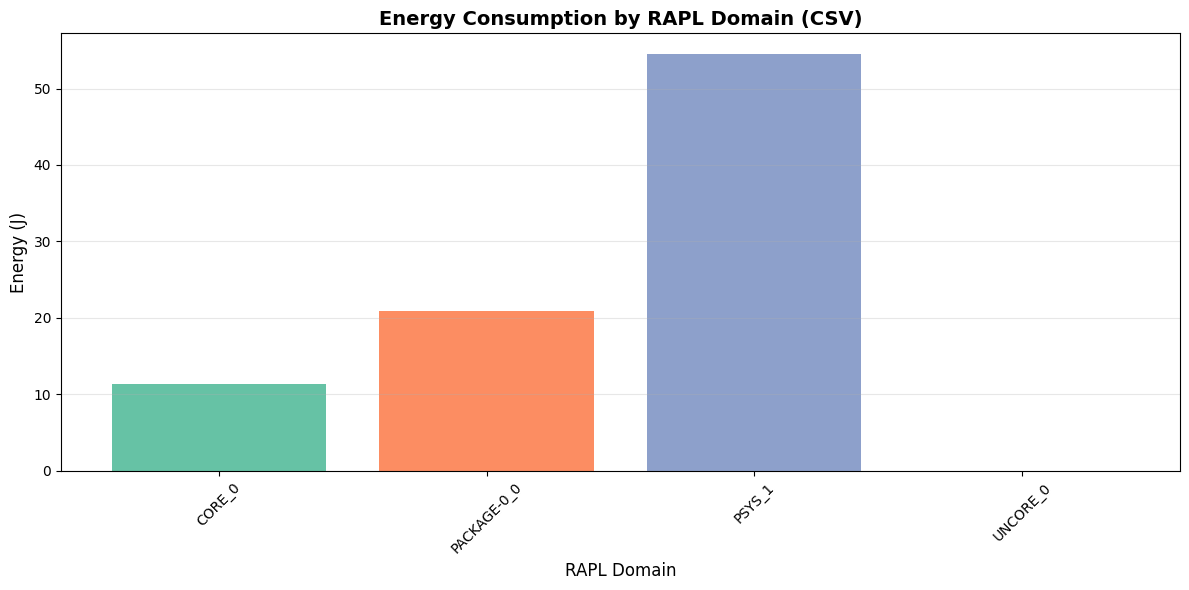

In [7]:
# Visualize CSV data
fig, ax = plt.subplots(figsize=(12, 6))

colors = sns.color_palette('Set2', len(df_csv_plot))
ax.bar(df_csv_plot['Domain'], df_csv_plot['Energy (J)'], color=colors)
ax.set_title('Energy Consumption by RAPL Domain (CSV)', fontsize=14, fontweight='bold')
ax.set_ylabel('Energy (J)', fontsize=12)
ax.set_xlabel('RAPL Domain', fontsize=12)
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()

## 3. Multiple Iterations (JSON)

In [8]:
# Load simple-iterations.json
iterations_data = pd.read_json('../examples/data/simple-iterations.json', typ='series')

print(f"Mode: {iterations_data['mode']}")
print(f"Number of iterations: {len(iterations_data['iterations'])}")

Mode: simple-iterations
Number of iterations: 5


In [9]:
# Convert to DataFrame with energy in Joules
df_iter_json = pd.DataFrame([
    {
        'Iteration': item['iteration'],
        **{domain: uj / 1_000_000 for domain, uj in item['energy_uj'].items()},
        'Duration (s)': item['duration_ms'] / 1000
    }
    for item in iterations_data['iterations']
])

df_iter_json

,Iteration,CORE_0,PACKAGE-0_0,PSYS_1,UNCORE_0,Duration (s)
0,0,10.541355,19.041821,49.815974,0.040222,3.129
1,1,11.804169,24.098327,62.031396,0.098023,3.665
2,2,14.240442,28.474597,69.201544,0.082580,3.750
3,3,10.555210,19.958445,49.993341,0.022766,3.012
4,4,13.531887,26.393854,64.126789,0.071960,3.583


## 4. Multiple Iterations (CSV)

In [10]:
# Load simple-iterations.csv - directly usable!
df_iter_csv = pd.read_csv('../examples/data/simple-iterations.csv', sep=';')
df_iter_csv

,iteration,CORE_0_uj,PACKAGE-0_0_uj,PSYS_1_uj,UNCORE_0_uj,duration_ms,exit_code
0,0,11535248,19794810,50161493,11963,3127,0
1,1,10472263,19094495,48181639,11535,2950,0
2,2,10019628,18616529,46952029,13916,2867,0
3,3,10026769,18650221,47110353,11536,2857,0
4,4,9940465,18365371,46293278,10498,2840,0


In [11]:
# Get domain columns
domain_cols_csv = [col for col in df_iter_csv.columns if col.endswith('_uj')]
print(f"Available domains: {', '.join([col.replace('_uj', '') for col in domain_cols_csv])}")

Available domains: CORE_0, PACKAGE-0_0, PSYS_1, UNCORE_0


## 5. Visualization - JSON Data

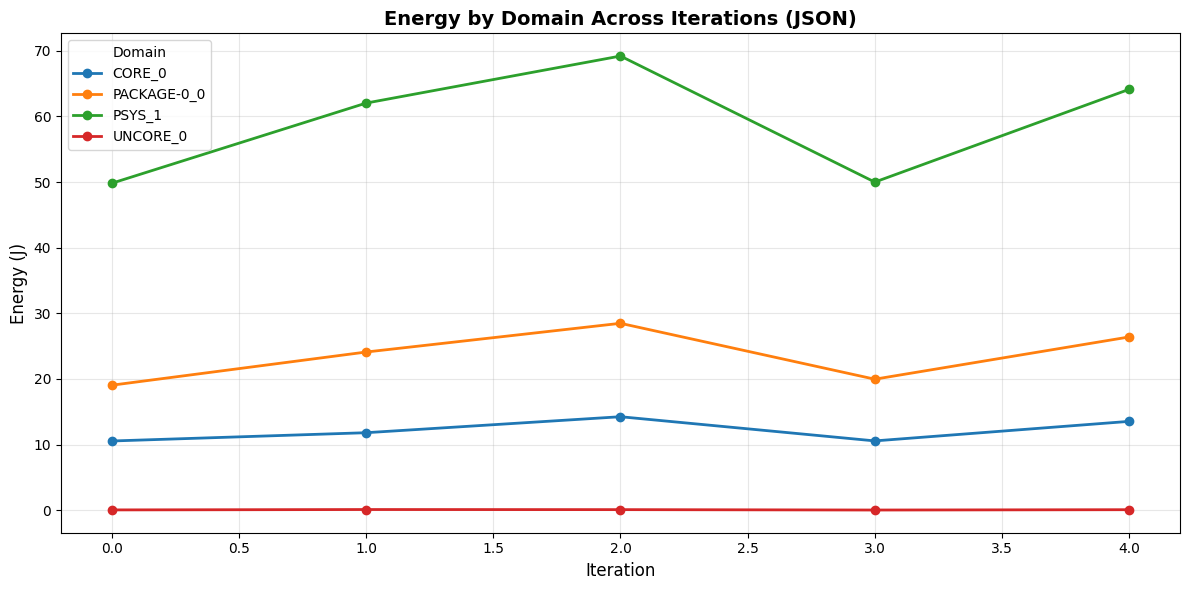

In [12]:
# Get domain columns (excluding metadata)
domain_cols_json = [col for col in df_iter_json.columns if col not in ['Iteration', 'Duration (s)']]

# Plot JSON data
fig, ax = plt.subplots(figsize=(12, 6))

for col in domain_cols_json:
    ax.plot(df_iter_json['Iteration'], df_iter_json[col], marker='o', label=col, linewidth=2)

ax.set_title('Energy by Domain Across Iterations (JSON)', fontsize=14, fontweight='bold')
ax.set_xlabel('Iteration', fontsize=12)
ax.set_ylabel('Energy (J)', fontsize=12)
ax.legend(title='Domain')
ax.grid(alpha=0.3)

plt.tight_layout()

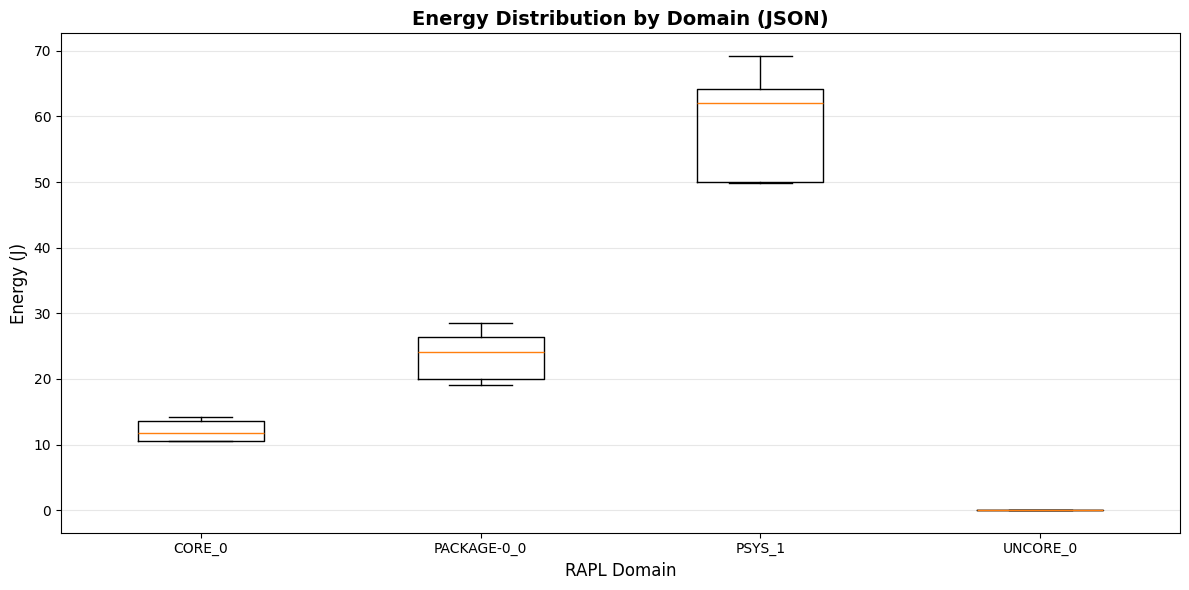

In [13]:
# Box plot - JSON
fig, ax = plt.subplots(figsize=(12, 6))

ax.boxplot([df_iter_json[col].values for col in domain_cols_json], tick_labels=domain_cols_json)
ax.set_title('Energy Distribution by Domain (JSON)', fontsize=14, fontweight='bold')
ax.set_ylabel('Energy (J)', fontsize=12)
ax.set_xlabel('RAPL Domain', fontsize=12)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()

## 6. Visualization - CSV Data

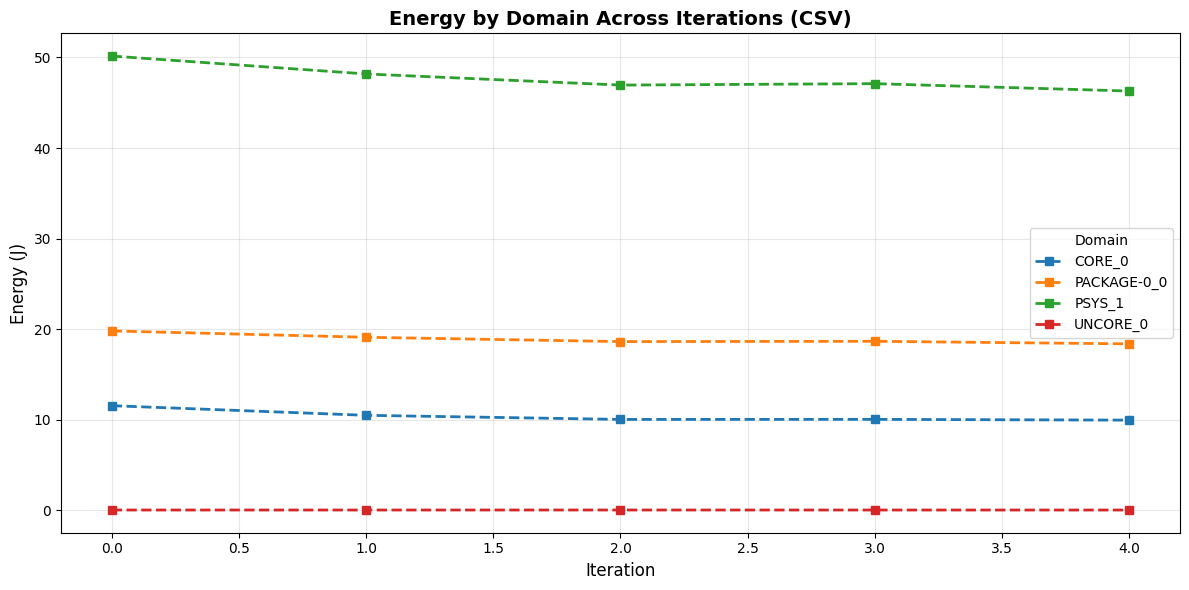

In [14]:
# Plot CSV data directly (in µJ)
fig, ax = plt.subplots(figsize=(12, 6))

for col in domain_cols_csv:
    label = col.replace('_uj', '')
    # Convert to J for display
    ax.plot(df_iter_csv['iteration'], df_iter_csv[col] / 1_000_000, 
            marker='s', label=label, linewidth=2, linestyle='--')

ax.set_title('Energy by Domain Across Iterations (CSV)', fontsize=14, fontweight='bold')
ax.set_xlabel('Iteration', fontsize=12)
ax.set_ylabel('Energy (J)', fontsize=12)
ax.legend(title='Domain')
ax.grid(alpha=0.3)

plt.tight_layout()

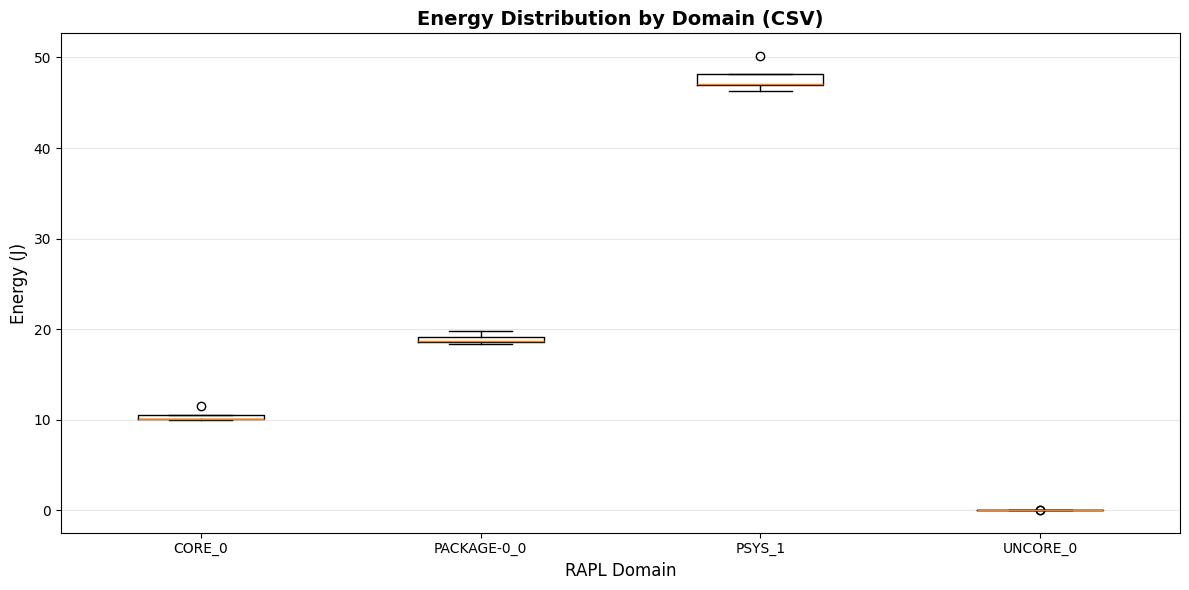

In [15]:
# Box plot - CSV (converted to J)
fig, ax = plt.subplots(figsize=(12, 6))

box_data = [df_iter_csv[col].values / 1_000_000 for col in domain_cols_csv]
labels = [col.replace('_uj', '') for col in domain_cols_csv]
ax.boxplot(box_data, tick_labels=labels)
ax.set_title('Energy Distribution by Domain (CSV)', fontsize=14, fontweight='bold')
ax.set_ylabel('Energy (J)', fontsize=12)
ax.set_xlabel('RAPL Domain', fontsize=12)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()